In [ ]:
import numpy as np
import math
import random
import scipy.linalg as la

### GRAPHS

def erdos_renyi_graph(N, M):
  graph = []
  node_list = [i for i in range(N)]
  numEdges = 0
  while numEdges < M:
    edge = random.sample(node_list, 2)
    if edge not in graph:
      numEdges += 1
      graph.append(edge)
  return graph
def find_degree(node, graph):
  degree = 0
  for edge in graph:
    if edge[0] == node:
      degree += 1
  return degree

def make_deg_dict(graph, curr_nodes):
  degDict = {}
  for i in curr_nodes:
    degDict[i] = find_degree(i, graph)
  return degDict

def sum_degs(graph, curr_nodes):
  sum = 0
  for node in curr_nodes:
    deg = find_degree(node, graph)
    sum += deg
  return sum

def pref_attachment(graph, curr_nodes, n, N):
  degDict = make_deg_dict(graph, curr_nodes)
  for i in range(N):
    new_node = n + i
    degDict[new_node] = 0
    for node in curr_nodes:
      deg = degDict[node]
      sum = sum_degs(graph, curr_nodes)
      p_node = deg/sum
      if np.random.rand() < p_node:
        graph.append([node, new_node])
        degDict[node] += 1
        graph.append([new_node, node])
        degDict[new_node] += 1
    curr_nodes.append(new_node)
  return graph
  
def barbell(n1, n2):
  graph = []
  for node in range(0, n1):
    for neighbor in range(0, n1):
      if (node != neighbor):
        graph.append([node, neighbor])
  for node in range(n1, n1+n2):
    for neighbor in range(n1, n1+n2):
      if (node != neighbor):
        graph.append([node, neighbor])
  node1 = np.random.randint(0, n1)
  node2 = np.random.randint(n1, n1+n2)
  graph.append([node1, node2])
  graph.append([node2, node1])
  return graph

def stochastic_block(n, r, P):
  graph = []
  node_list = np.arange(n)
  communities = np.array_split(node_list, r)
  for i in range(r):
    for j in range(r):
      C_i = communities[i]
      C_j = communities[j]
      p_ij = P[i][j]
      for node1 in C_i:
        for node2 in C_j:
          if node1 != node2:
            if np.random.rand() < p_ij:
                graph.append([node1, node2])
  return graph

def tuples_to_dict(graph, node_list):
  graph_dict = {}
  for i in node_list:
    graph_dict[i] = []
  for edge in graph: 
    graph_dict[edge[0]].append(edge[1])
  return graph_dict

### SPECTRAL PARTITIONING

def find_degrees(graph_dict, node_list):
  degs = []
  for i in node_list:
    degs.append(len(graph_dict[i]))
  return degs
 


def node_index(node, node_list):
  for index in range(len(node_list)):
    if (node_list[index] == node):
      return index
  # return np.where(node_list == node)

def graph_to_laplacian(graph, node_list):
  graph_dict = tuples_to_dict(graph, node_list)
  D = find_degrees(graph_dict, node_list)
  L = np.diag(D)
  for edge in graph:
    L[node_index(edge[0], node_list)][node_index(edge[1], node_list)] = -1
    L[node_index(edge[1], node_list)][node_index(edge[0], node_list)] = -1
  return L


def edge_density(part1, part2, graph_dict, N):
  E = 0
  for node in part1:
    for neighbor in graph_dict[node]:
      if neighbor in part2:
        E += 1

  return N*(E/(len(part1)*len(part2)))

def sparsest_cut(graph, node_list):
  L = graph_to_laplacian(graph, node_list)
  results = la.eig(L)
  eigvalues = results[0].real
  eigvectors = results[1]
  idx = eigvalues.argsort()[::-1]
  # eigvalues = eigvalues[idx]   
  eigvectors = eigvectors[:,idx]  
  second_smallest_vec = eigvectors[:, -2]
  vec = second_smallest_vec.T
  ids = vec.argsort()[::-1]

  curr_density = len(node_list)
  curr_i = 1
  for i in range(int(len(node_list)/4), int((3*len(node_list))/4)):
    part1 = []
    part2 = []
    for id in ids[:i]:
      part1.append(node_list[id])
    for j in ids[i:]:
      part2.append(node_list[j])
    density = edge_density(part1, part2, tuples_to_dict(graph, node_list), len(node_list))
    # print (density)
    if density < curr_density and density > 0:
      # print (density)
      curr_density = density
      # print (curr_density)
      curr_i = i
  # print (curr_density)
  part1 = ids[:curr_i]
  part2 = ids[curr_i:]
  nodes1 = []
  for i in part1:
    nodes1.append(node_list[i])
  nodes2 = []
  for i in part2:
    nodes2.append(node_list[i])
  return nodes1, nodes2

def updated_graph(graph, nodes_to_remove):
  new_graph = []
  for edge in graph:
    if edge[0] not in nodes_to_remove and edge[1] not in nodes_to_remove:
      new_graph.append(edge)
  return new_graph
  

def well_balanced_cut(graph, N):
  cluster_size = 0
  cluster1 = []
  cluster2 = np.arange(N)
  curr_graph = graph
  curr_node_list = cluster2
  while len(cluster1) < N/2:
    # print ("other" + str(cluster1))
    # print (curr_node_list)
    cut = sparsest_cut(curr_graph, curr_node_list)
    cut_sizes = [len(cut[0]), len(cut[1])]
    if cut_sizes[0] < cut_sizes[1]:
      cluster1 = cut[0] + cluster1
      curr_graph = updated_graph(curr_graph, cut[0])
      cluster2 = cut[1]
    else:
      # print (len(cut[0]))
      cluster1 = cut[1] + cluster1
      curr_graph = updated_graph(curr_graph, cut[1])
      cluster2 = cut[0]
    curr_node_list = cluster2
  return cluster1, cluster2

    

N = 10
r = 2
P = np.zeros((r,r))
P[0][0] = 0.6
P[1][1] = 0.6
P[0][1] = 0.2
P[1][0] = 0.2
# graph = barbell(50, 50)
graph = stochastic_block(N, r, P)
print (graph)
# print (graph)
# nodes = sparsest_cut(graph, np.arange(N))
print (well_balanced_cut(graph, N))
# print (len(nodes[0]))
# print (nodes)
# we have to find a way to do this sparsest cut iteratively until we speerate at least half of the nodes from the graph,
# (because right now, it is seperating a few nodes from the larger graph)
# the problem I see with using the iterative approach is that it might not divide the set into 2 well connected clusters but instead
# into a cluster of well connected ones + many small connected clsuters

  

[[0, 2], [0, 3], [1, 0], [1, 2], [1, 3], [2, 0], [2, 1], [2, 3], [2, 4], [3, 1], [3, 2], [4, 0], [4, 3], [0, 8], [1, 9], [2, 6], [3, 6], [4, 6], [5, 3], [5, 4], [6, 1], [7, 0], [9, 2], [5, 7], [6, 7], [6, 9], [7, 5], [7, 6], [7, 8], [7, 9], [8, 5], [8, 6], [8, 7]]
([8, 0, 5, 4, 3], [7, 6, 1, 2, 9])


In [ ]:
def percolation(neighbors_per_node, transmissionRate, recoveryRates):
    new_graph = []
    for node in neighbors_per_node:
        # print(recoveryRates[node])
        recoveryTime = np.random.exponential(1/recoveryRates[node])
        for neighbor in neighbors_per_node[node]:
            transmissionTime = np.random.exponential(1/transmissionRate)
            if (transmissionTime <= recoveryTime):
                new_graph.append([node, neighbor])
    return new_graph              

def find_connected_nodes(node, graph_dict, connected_component):
  if node not in connected_component:
    connected_component.append(node)
  for neighbor in graph_dict[node]:
    if neighbor not in connected_component:
      find_connected_nodes(neighbor, graph_dict, connected_component)

def find_entire_connection(infected_nodes, neighbors_per_node):
  connected_nodes = []
  for node in infected_nodes:
    find_connected_nodes(node, neighbors_per_node, connected_nodes)
  return connected_nodes

def calculateFinalInfection(graph, source, numOfNodes, numOfTrials, transmissionRate, budget, neighbors_per_node, recoveryRates):
  num_infected = []
  for _ in range(numOfTrials):
    graph1 = percolation(neighbors_per_node, transmissionRate, recoveryRates)
    neighbors_per_node2 = tuples_to_dict(graph1, np.arange(numOfNodes))
    infected_nodes = find_entire_connection(source, neighbors_per_node2)
    num_infected.append(len(infected_nodes))
  return np.mean(num_infected)

def find_crossing_edges(graph, part1, part2):
  nodes = []
  for edge in graph:
    if (edge[0] in part1 and edge[1] in part2) or (edge[1] in part1 and edge[0] in part2):
      # print (edge)
      if edge[0] not in nodes:
        nodes.append(edge[0])
      if edge[1] not in nodes:
        nodes.append(edge[1])
  # print (nodes)
  return nodes

def min_cut_antidotes(graph, N, initial_recovery_rate, budget, part1, part2):
  recoveryRates = {}
  # print ("part1:" + str(part1))
  # print ("part2:" + str(part2))
  node_list = np.arange(N)
  nodes = find_crossing_edges(graph, part1, part2)
  antidote_amt = initial_recovery_rate + budget/len(nodes)
  for node in node_list:
    if node in nodes:
      recoveryRates[node] = antidote_amt
    else:
      recoveryRates[node] = initial_recovery_rate
  return recoveryRates

def min_cut_antidotes2(graph, N, initial_recovery_rate, budget, part1, part2, limit_recovery):
  recoveryRates = {}
  # print ("part1:" + str(part1))
  # print ("part2:" + str(part2))
  node_list = np.arange(N)
  nodes = find_crossing_edges(graph, part1, part2)
  if (len(node_list) * limit_recovery >= budget):
    antidote_amt = initial_recovery_rate + budget/len(nodes)
    for node in node_list:
      if node in nodes:
        recoveryRates[node] = antidote_amt
      else:
        recoveryRates[node] = initial_recovery_rate
  else:
    antidote_amt = initial_recovery_rate + limit_recovery
    antidote_amt2 = (budget - (len(nodes) * limit_recovery)) / len(part2)
    for node in node_list:
      if node in nodes:
        recoveryRates[node] = antidote_amt
        if (node in part2):
          recoveryRates[node] += antidote_amt2
      elif (node in part2):
        recoveryRates[node] = initial_recovery_rate + antidote_amt2
      else:
        recoveryRates[node] = initial_recovery_rate
  return recoveryRates


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def degree_proportional(graph, initial_recovery_rate, budget, numOfNodes):
    degDict = {}
    sum = len(graph)
    for edge in graph:
        if edge[0] not in degDict:
            degDict[edge[0]] = 0
        degDict[edge[0]] += 1
    recoveryRates = {}
    for node in range(numOfNodes):
        if node in degDict:
          recoveryRates[node] = initial_recovery_rate + (degDict[node]/sum)*budget
        else: 
          recoveryRates[node] = initial_recovery_rate
    return recoveryRates 

def uniform_recovery(N, budget, initial_recovery_rate):
  recoveryRates = {}
  for node in range(N):
    recoveryRates[node] = budget/N + initial_recovery_rate
  return recoveryRates

def antidote_cluster(cluster, node_list, budget, initial_recovery_rate):
  rec = {}
  amt = initial_recovery_rate + budget/len(cluster)
  for node in node_list:
    if node in cluster:
      rec[node] = amt
    else:
      rec[node] = initial_recovery_rate
  return rec



0.02
0.03
0.039999999999999994
0.049999999999999996


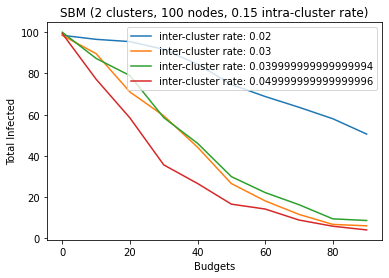

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

N = 100
r = 2
beta = 0.1
budgets = np.arange(0, N, 10)
numTrials = 200
probabalities = np.arange(0.020, 0.055, 0.01)
node_list = np.arange(N)
initial_recovery_rate = 0.01

for prob in probabalities:
  print(prob)
  P = np.zeros((r,r))
  P[0][0] = 0.15
  P[1][1] = 0.15
  P[0][1] = prob
  P[1][0] = prob
  graph = stochastic_block(N, r, P)
  node_list = np.arange(N)
  neighbors_per_node = tuples_to_dict(graph, node_list)
  part1, part2 = sparsest_cut(graph, node_list)
  source = random.sample(part2, 1)
  Y = []
  for budget in budgets:
    recoveryRates = min_cut_antidotes(graph, N, initial_recovery_rate, budget, part1, part2)
    inf = (calculateFinalInfection(graph, source, N, numTrials, beta, budget, neighbors_per_node, recoveryRates))
    Y.append(inf)

  plt.plot(budgets, Y, label="inter-cluster rate: " + str(prob))

plt.xlabel("Budgets")
plt.ylabel("Total Infected")
plt.title("SBM (2 clusters, 100 nodes, 0.15 intra-cluster rate)")
plt.legend()

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400


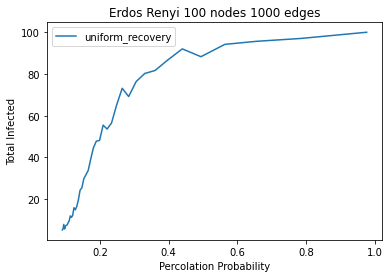

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

numNodes = 100
numEdges = 1000
budgets = np.arange(0, 405, 10)
numTrials = 300
initial_recovery_rate = 0.01
beta = 0.4
node_list = np.arange(numNodes)
graph = erdos_renyi_graph(numNodes, numEdges)
neighbors_per_node = tuples_to_dict(graph, node_list)
part1, part2 = sparsest_cut(graph, node_list)
source = random.sample(part2, 1)

Y1 = []
Y2 = []
Y3 = []
Y4 = []
Y5 = []

perc_prob = []
for budget in budgets:
  rho = initial_recovery_rate + (budget / numNodes)
  perc_prob.append(beta / (beta + rho))

for budget in budgets:
  print(budget)

  # recoveryRates1 = min_cut_antidotes(graph, numNodes, initial_recovery_rate, budget, part1, part2)
  # inf1 = calculateFinalInfection(graph, source, numNodes, numTrials, beta, budget, neighbors_per_node, recoveryRates1)
  # Y1.append(inf1)

  # recoveryRates2 = min_cut_antidotes2(graph, numNodes, initial_recovery_rate, budget, part1, part2, 0.1)
  # inf2 = calculateFinalInfection(graph, source, numNodes, numTrials, beta, budget, neighbors_per_node, recoveryRates2)
  # Y2.append(inf2)

  # recoveryRates3 = antidote_cluster(part2, node_list, budget, initial_recovery_rate)
  # inf3 = calculateFinalInfection(graph, source, numNodes, numTrials, beta, budget, neighbors_per_node, recoveryRates3)
  # Y3.append(inf3)

  # recoveryRates4 = degree_proportional(graph, initial_recovery_rate, budget, numNodes)
  # inf4 = calculateFinalInfection(graph, source, numNodes, numTrials, beta, budget, neighbors_per_node, recoveryRates4)
  # Y4.append(inf4)

  recoveryRates5 = uniform_recovery(numNodes, budget, initial_recovery_rate)
  inf5 = calculateFinalInfection(graph, source, numNodes, numTrials, beta, budget, neighbors_per_node, recoveryRates5)
  Y5.append(inf5)

# print(Y1)
# print(Y2)
# plt.plot(budgets, Y1, label="boundary nodes")
# plt.plot(budgets, Y2, label="boundary nodes (limit recovery: 0.1) + edges")
# plt.plot(budgets, Y3, label="cluster (cheating)")
# plt.plot(budgets, Y4, label="degree_proportional")
plt.plot(perc_prob, Y5, label="uniform_recovery")

plt.xlabel("Percolation Probability")
plt.ylabel("Total Infected")
plt.title("Erdos Renyi " + str(numNodes) + " nodes " + str(numEdges) + " edges")
plt.legend()

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400


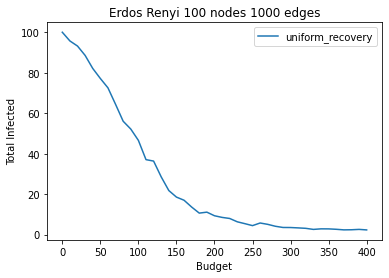

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

numNodes = 100
numEdges = 1000
budgets = np.arange(0, 405, 10)
numTrials = 300
initial_recovery_rate = 0.01
beta = 0.25
node_list = np.arange(numNodes)
graph = erdos_renyi_graph(numNodes, numEdges)
neighbors_per_node = tuples_to_dict(graph, node_list)
part1, part2 = sparsest_cut(graph, node_list)
source = random.sample(part2, 1)

Y1 = []
Y2 = []
Y3 = []
Y4 = []
Y5 = []

perc_prob = []
rhos = []
for budget in budgets:
  rho = initial_recovery_rate + (budget / numNodes)
  rhos.append(rho)
  perc_prob.append(beta / (beta + rho))

for budget in budgets:
  print(budget)

  # recoveryRates1 = min_cut_antidotes(graph, numNodes, initial_recovery_rate, budget, part1, part2)
  # inf1 = calculateFinalInfection(graph, source, numNodes, numTrials, beta, budget, neighbors_per_node, recoveryRates1)
  # Y1.append(inf1)

  # recoveryRates2 = min_cut_antidotes2(graph, numNodes, initial_recovery_rate, budget, part1, part2, 0.1)
  # inf2 = calculateFinalInfection(graph, source, numNodes, numTrials, beta, budget, neighbors_per_node, recoveryRates2)
  # Y2.append(inf2)

  # recoveryRates3 = antidote_cluster(part2, node_list, budget, initial_recovery_rate)
  # inf3 = calculateFinalInfection(graph, source, numNodes, numTrials, beta, budget, neighbors_per_node, recoveryRates3)
  # Y3.append(inf3)

  # recoveryRates4 = degree_proportional(graph, initial_recovery_rate, budget, numNodes)
  # inf4 = calculateFinalInfection(graph, source, numNodes, numTrials, beta, budget, neighbors_per_node, recoveryRates4)
  # Y4.append(inf4)

  recoveryRates5 = uniform_recovery(numNodes, budget, initial_recovery_rate)
  inf5 = calculateFinalInfection(graph, source, numNodes, numTrials, beta, budget, neighbors_per_node, recoveryRates5)
  Y5.append(inf5)

# print(Y1)
# print(Y2)
# plt.plot(budgets, Y1, label="boundary nodes")
# plt.plot(budgets, Y2, label="boundary nodes (limit recovery: 0.1) + edges")
# plt.plot(budgets, Y3, label="cluster (cheating)")
# plt.plot(budgets, Y4, label="degree_proportional")
plt.plot(budgets, Y5, label="uniform_recovery")

plt.xlabel("Budget")
plt.ylabel("Total Infected")
plt.title("Erdos Renyi " + str(numNodes) + " nodes " + str(numEdges) + " edges")
plt.legend()

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400


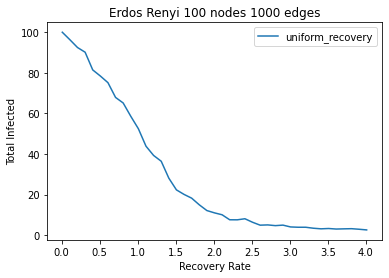

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

numNodes = 100
numEdges = 1000
budgets = np.arange(0, 405, 10)
numTrials = 300
initial_recovery_rate = 0.01
beta = 0.25
node_list = np.arange(numNodes)
graph = erdos_renyi_graph(numNodes, numEdges)
neighbors_per_node = tuples_to_dict(graph, node_list)
part1, part2 = sparsest_cut(graph, node_list)
source = random.sample(part2, 1)

Y1 = []
Y2 = []
Y3 = []
Y4 = []
Y5 = []

perc_prob = []
rhos = []
for budget in budgets:
  rho = initial_recovery_rate + (budget / numNodes)
  rhos.append(rho)
  perc_prob.append(beta / (beta + rho))

for budget in budgets:
  print(budget)

  # recoveryRates1 = min_cut_antidotes(graph, numNodes, initial_recovery_rate, budget, part1, part2)
  # inf1 = calculateFinalInfection(graph, source, numNodes, numTrials, beta, budget, neighbors_per_node, recoveryRates1)
  # Y1.append(inf1)

  # recoveryRates2 = min_cut_antidotes2(graph, numNodes, initial_recovery_rate, budget, part1, part2, 0.1)
  # inf2 = calculateFinalInfection(graph, source, numNodes, numTrials, beta, budget, neighbors_per_node, recoveryRates2)
  # Y2.append(inf2)

  # recoveryRates3 = antidote_cluster(part2, node_list, budget, initial_recovery_rate)
  # inf3 = calculateFinalInfection(graph, source, numNodes, numTrials, beta, budget, neighbors_per_node, recoveryRates3)
  # Y3.append(inf3)

  # recoveryRates4 = degree_proportional(graph, initial_recovery_rate, budget, numNodes)
  # inf4 = calculateFinalInfection(graph, source, numNodes, numTrials, beta, budget, neighbors_per_node, recoveryRates4)
  # Y4.append(inf4)

  recoveryRates5 = uniform_recovery(numNodes, budget, initial_recovery_rate)
  inf5 = calculateFinalInfection(graph, source, numNodes, numTrials, beta, budget, neighbors_per_node, recoveryRates5)
  Y5.append(inf5)

# print(Y1)
# print(Y2)
# plt.plot(budgets, Y1, label="boundary nodes")
# plt.plot(budgets, Y2, label="boundary nodes (limit recovery: 0.1) + edges")
# plt.plot(budgets, Y3, label="cluster (cheating)")
# plt.plot(budgets, Y4, label="degree_proportional")
plt.plot(rhos, Y5, label="uniform_recovery")

plt.xlabel("Recovery Rate")
plt.ylabel("Total Infected")
plt.title("Erdos Renyi " + str(numNodes) + " nodes " + str(numEdges) + " edges")
plt.legend()

0
5
10
15
20
25
30
35
40
45
50
[99.67, 99.32333333333334, 96.32, 97.59666666666666, 97.18666666666667, 95.11333333333333, 92.98333333333333, 91.53, 92.00333333333333, 90.14, 89.95666666666666]
[99.67, 98.64666666666666, 97.97, 97.55333333333333, 95.16666666666667, 91.77, 92.99666666666667, 90.54, 90.72666666666667, 87.76, 86.22666666666667]


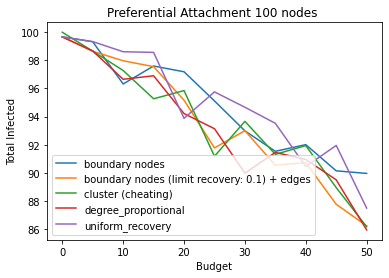

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

numNodes = 100
numEdges = 1000
budgets = np.arange(0, 55, 5)
numTrials = 300
initial_recovery_rate = 0.01
beta = 0.4
node_list = np.arange(numNodes)
graph = pref_attachment(graph, [0,1], 2, numNodes - 2)
neighbors_per_node = tuples_to_dict(graph, node_list)
part1, part2 = sparsest_cut(graph, node_list)
source = random.sample(part2, 1)

Y1 = []
Y2 = []
Y3 = []
Y4 = []
Y5 = []

for budget in budgets:
  print(budget)

  recoveryRates1 = min_cut_antidotes(graph, numNodes, initial_recovery_rate, budget, part1, part2)
  inf1 = calculateFinalInfection(graph, source, numNodes, numTrials, beta, budget, neighbors_per_node, recoveryRates1)
  Y1.append(inf1)

  recoveryRates2 = min_cut_antidotes2(graph, numNodes, initial_recovery_rate, budget, part1, part2, 0.1)
  inf2 = calculateFinalInfection(graph, source, numNodes, numTrials, beta, budget, neighbors_per_node, recoveryRates2)
  Y2.append(inf2)

  recoveryRates3 = antidote_cluster(part2, node_list, budget, initial_recovery_rate)
  inf3 = calculateFinalInfection(graph, source, numNodes, numTrials, beta, budget, neighbors_per_node, recoveryRates3)
  Y3.append(inf3)

  recoveryRates4 = degree_proportional(graph, initial_recovery_rate, budget, numNodes)
  inf4 = calculateFinalInfection(graph, source, numNodes, numTrials, beta, budget, neighbors_per_node, recoveryRates4)
  Y4.append(inf4)

  recoveryRates5 = uniform_recovery(numNodes, budget, initial_recovery_rate)
  inf5 = calculateFinalInfection(graph, source, numNodes, numTrials, beta, budget, neighbors_per_node, recoveryRates5)
  Y5.append(inf5)

print(Y1)
print(Y2)
plt.plot(budgets, Y1, label="boundary nodes")
plt.plot(budgets, Y2, label="boundary nodes (limit recovery: 0.1) + edges")
plt.plot(budgets, Y3, label="cluster (cheating)")
plt.plot(budgets, Y4, label="degree_proportional")
plt.plot(budgets, Y5, label="uniform_recovery")

plt.xlabel("Budget")
plt.ylabel("Total Infected")
plt.title("Preferential Attachment " + str(numNodes) + " nodes ")
plt.legend()